# Functions, imports etc. Just run without changes

In [1]:
from rdkit import Chem
from rdkit.SimDivFilters import rdSimDivPickers  
from tqdm import tqdm 
from rdkit.Chem import AllChem
import numpy as np
import umap.umap_ as umap
from rdkit import RDLogger                                                                                                                                                               
RDLogger.DisableLog('rdApp.*')
import pandas as pd
import matplotlib.pyplot as plt
import re
import numpy as np
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.SaltRemover import SaltRemover
import pandas as pd
from tqdm import tqdm as tqdm
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

seed = 42

def santize_molecules(paths:list):
    """Sanitize molecules 

    Args:
        paths (list[str]): List with the paths to .sdf files
        names (list[str]): Custom name for the molecules. It will be named after the file it comes from. Default will have the same name as the file

    Returns:
        dataframe (pd.DataFrame): Dataframe with sanitize and named molecules
    """
    # prepare santizers 
    salt_remover = SaltRemover() 
    uncharger    = rdMolStandardize.Uncharger()
    clean_data = []
    for path in paths:
        supplier = Chem.SDMolSupplier(path, sanitize=True, removeHs=False)
        for mol in tqdm(supplier, desc='Cleaning'):
            if mol is None:
                continue
            try:
                # sanitize
                Chem.SanitizeMol(mol, catchErrors=True)
                # rm salt 
                mol = salt_remover.StripMol(mol)
                # Neutralize
                mol = uncharger.uncharge(mol, )
                # Sanitize again
                Chem.SanitizeMol(mol)
                # canonical smile
                smi = Chem.MolToSmiles(mol, isomericSmiles=True)
                # Get name if exists
                prop_dict = mol.GetPropsAsDict()
                name = prop_dict.get("Compound_ID")
                db = re.split(r'\d+', name)[0]
                clean_data.append((smi, name, db))

            except Exception:
                # discard exceptions
                continue

    df= pd.DataFrame(clean_data, columns=["SMILES", "Name", "Database"])
    print(df.head())
    print(len(df))
    return df


def _mols_and_fps(df, smiles_col="SMILES", radius=2, nBits=2048) -> pd.DataFrame:
    """Convert a SMILES column to RDKit mols + Morgan/ECFP4 fingerprints.
            ) -> (rdkit.mol, fingerprints, idx)

    Args:
        df(pd.Dataframe): Dataframe containg  at least the SMILES strings 
        smiles_col(str): Name of the column containing the smiles strings
        radius(int): Radius for ECFP fingerprints. Defaults to 2
        nBits(int): Size of the ECFP fingerprint. Default to 2048

    Returns:
        dataframe (pd.Dataframe): Dataframe with the labels column added
    """ 
    fps = []
    for i, smi in tqdm(enumerate(df[smiles_col]), desc='Calculating fingerprints', total=len(df)):
        try:
            m = Chem.MolFromSmiles(smi)
        except Exception as e:
            print(f'An exception ocurred with {smi}: {e}')
        if m:
            fps.append(AllChem.GetMorganFingerprintAsBitVect(m, radius, nBits))
    return fps


def picker(n_pick:int, df:pd.DataFrame, smiles_col:str="SMILES", radius:int=2, nBits:int=2048, plot:bool=True, seed:int=42):
    """Select N molecules from a dataset using MaxMinPicker selection. Optinally visualize through TMAP

    Args:
        n (int): Number of molecules to select from the dataset
        df (pd.DataFrame): _description_
        smiles_col (str, optional): _description_. Defaults to "SMILES".
        radius (int, optional): _description_. Defaults to 2.
        nBits (int, optional): _description_. Defaults to 2048.
        plot (bool, optional): _description_. Defaults to True.
        seed (int, optional): _description_. Defaults to 42.
    """

    assert n_pick < len(df), f"The number of molecules to select {n_pick} cannot be larger than the dataframe {len(df)}"
    fps= _mols_and_fps(df=df, smiles_col=smiles_col, radius=radius, nBits=nBits) 
    picker = rdSimDivPickers.MaxMinPicker()               
    picks = picker.LazyBitVectorPick(fps,           # list[ExplicitBitVect] (fingerprints)
                                    len(fps),      # pool size
                                    n_pick,        # how many to pick
                                    [],            # no initial seed set
                                    seed)            # RNG seed


    return df.iloc[picks], fps, picks



/Users/afloresep/miniforge3/envs/ClusterMol/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Sanitize molecules

In [2]:
paths = ['/Users/afloresep/work/ClusterMol/notebook/Welab_Chemical_library_fixed.sdf','/Users/afloresep/work/ClusterMol/notebook/Innopharm_chemical_library_fixed.sdf']
df = santize_molecules(paths)

## Optional: Save the dataframe for future runs
# df.to_csv('sanitized_molecules.csv', index=False) 

## If saved dataframe before, read:
#df = pd.read_csv('sanitized_molecules.csv')

Cleaning: 100%|██████████| 60698/60698 [00:31<00:00, 1923.44it/s]

                                              SMILES          Name Database
0                 Clc1ccc(C2=CCN(CCCCn3cncn3)CC2)cc1  WLB0005982.M      WLB
1  NS(=O)(=O)c1ccc(N2N=C(C(F)(F)F)C[C@H]2c2ccc(F)...    WLB0006232      WLB
2  NS(=O)(=O)c1ccc(N2N=C(C(F)(F)F)CC2c2ccc(F)cc2F...    WLB0006087      WLB
3                                N=C(N)Sc1cc(O)ccc1O  WLB0001001.A      WLB
4  O=S(=O)(c1cc(O)ccc1O)N1CCN(S(=O)(=O)c2cc(O)ccc...    WLB0001003      WLB
131400


# Picker
### Params:

- `n_pick`: number of molecules to select 
- `df`: Dataframe with sanitized molecules 
- `smiles_col`: Name of the column in `df` containing the SMILES strings
- `radius`: Radius for ECFP
- `nBits`: nBits for ECFP 




In [4]:
df_picked, fps, picks = picker(n_pick=5000, df=df, smiles_col="SMILES", radius=2, nBits=2048, plot=True, seed=42)
## Optional: Save dataframe with picked molecules
# df_picked.to_csv('selection.csv', index=False)

Calculating fingerprints: 100%|██████████| 131400/131400 [00:13<00:00, 9907.18it/s] 


## Compute UMAP

In [5]:
# ################ Leave as is ###############
#convert ot binary again 
arr = np.asarray([np.frombuffer(fp.ToBitString().encode(), 'S1').astype(np.int8) for fp in fps])
reducer = umap.UMAP(n_neighbors=15,min_dist=0.1, metric='jaccard', random_state=seed)
coords = reducer.fit_transform(arr)     
mask = np.zeros(len(fps), dtype=bool)
mask[picks] = True          # True for the chosen molecules


/Users/afloresep/miniforge3/envs/ClusterMol/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/afloresep/miniforge3/envs/ClusterMol/lib/python3.13/site-packages/umap/umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(
/Users/afloresep/miniforge3/envs/ClusterMol/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
/Users/afloresep/miniforge3/envs/ClusterMol/lib/python3.13/site-packages/pynndescent/pynndescent_.py:939: UserWarning: Failed to correctly find n_neighbors for some samples. Results may be less than ideal. Try re-running with different parameters.
  warn

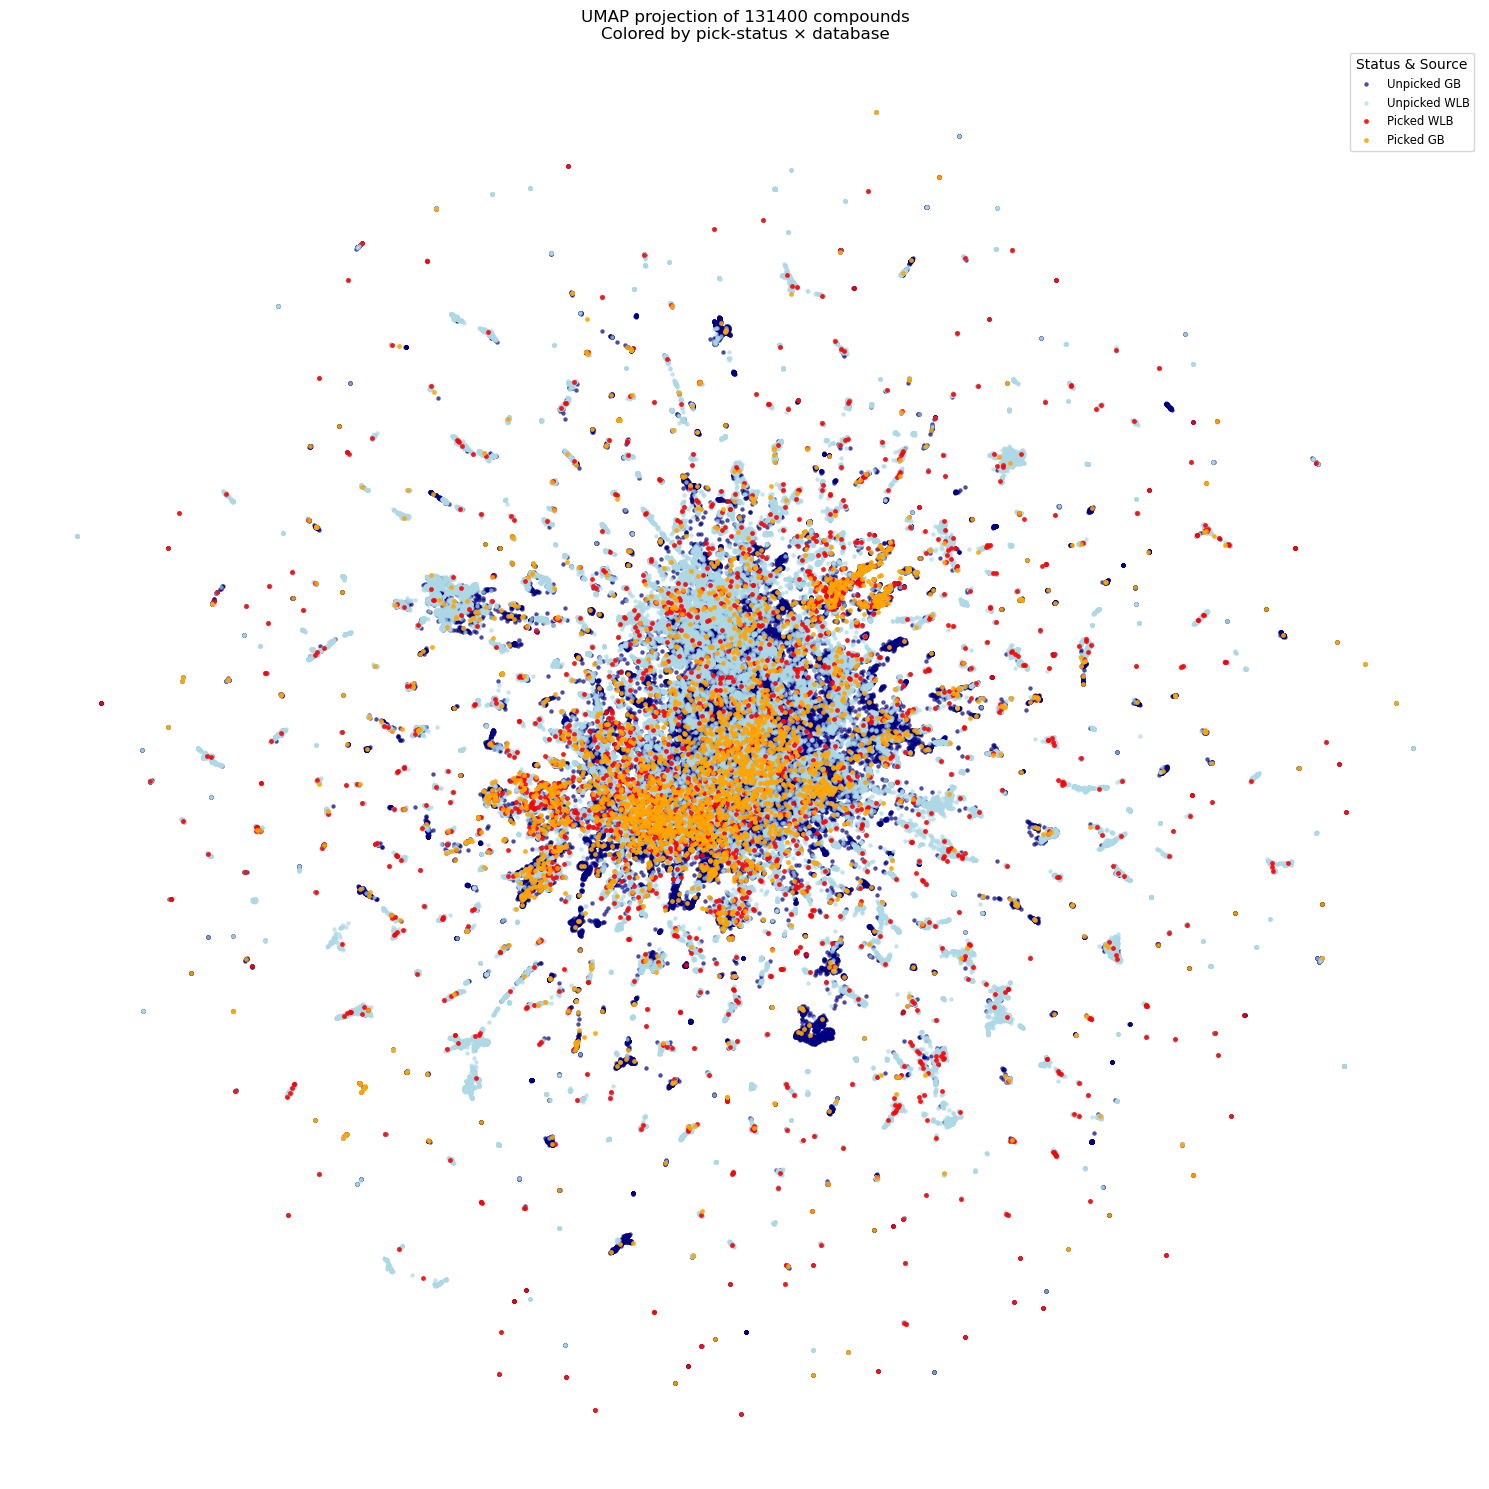

In [6]:
# # Change if you want
# #####################################################
figsize:tuple = (12, 12)
dpi:int = 110
unpicked_size:int= 10
unpicked_color:str='blue'
unpicked_alpha:float=0.7
picked_size:int=12
picked_color:str='red'
picked_alpha:float=0.9
# #####################################################

db = df['Database'].values
picked_db1   = mask  & (db == 'WLB')
picked_db2   = mask  & (db == 'CBG')
unpicked_db1 = ~mask & (db == 'WLB')
unpicked_db2 = ~mask & (db == 'CBG')

# plot
plt.figure(figsize=(15, 15))
h4 = plt.scatter(coords[unpicked_db2, 0], coords[unpicked_db2, 1],
                 s=unpicked_size, c='navy',      alpha=unpicked_alpha, label='Unpicked GB',  linewidths=0)
h3 = plt.scatter(coords[unpicked_db1, 0], coords[unpicked_db1, 1],
                 s=unpicked_size, c='lightblue', alpha=unpicked_alpha, label='Unpicked WLB', linewidths=0)

h1 = plt.scatter(coords[picked_db1, 0],   coords[picked_db1, 1],
                 s=picked_size,   c='red',     alpha=picked_alpha,   label='Picked WLB',   linewidths=0)
h2 = plt.scatter(coords[picked_db2, 0],   coords[picked_db2, 1],
                 s=picked_size,   c='orange',  alpha=picked_alpha,   label='Picked GB',    linewidths=0)

plt.legend(scatterpoints=1, fontsize='small', frameon=True, title='Status & Source')
plt.title(f'UMAP projection of {len(df)} compounds\nColored by pick-status × database')
plt.axis('off')
plt.tight_layout()
plt.show()
# #############################################